In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output

import gym_super_mario_bros
from gym_super_mario_bros.actions import SIMPLE_MOVEMENT, COMPLEX_MOVEMENT, RIGHT_ONLY
from gym import wrappers
from nes_py.wrappers import BinarySpaceToDiscreteSpaceEnv


import keras
from keras.models import Sequential, Model
from keras.layers import Input, Conv2D, Dense, Flatten, MaxPooling1D, SeparableConv2D, Activation, Lambda
from keras.layers import AveragePooling2D, MaxPooling2D, LSTM, Concatenate, Reshape, GRU, BatchNormalization
from keras.initializers import Constant
from keras.constraints import MaxNorm
from keras.applications.xception import Xception
from keras.applications.mobilenet_v2 import MobileNetV2

version = 3
movement_type = SIMPLE_MOVEMENT

def make_env(version, movement_type):
    env = gym_super_mario_bros.make('SuperMarioBros-v' + str(version))
    env = BinarySpaceToDiscreteSpaceEnv(env, movement_type)
    return env

env = make_env(version, movement_type)
obs_shape = env.observation_space.shape
square_shape = (16,16)
strides = int(square_shape[0]/2)
output_dim = len(env.get_action_meanings())

def get_mario_model(nproc = 1, obs_shape = obs_shape, square_shape = square_shape, strides = strides, output_dim = output_dim, hidden_size = 10):
    model = Sequential()
    model.add(Lambda(lambda x: x/255.0, batch_input_shape = np.concatenate(([1],obs_shape)), output_shape=None, mask=None, arguments=None))
    model.add(Conv2D(kernel_size = (8,8), filters=1, strides = 8, padding = 'same'))
    model.add(Activation(activation='relu'))
    model.add(Conv2D(kernel_size = (4,4), filters=2, strides = 2, padding = 'same'))
    model.add(Activation(activation='relu'))
    model.add(Conv2D(kernel_size = (2,2), filters=4, strides = 2, padding = 'same'))
    model.add(Activation(activation='relu'))
    model.add(Conv2D(kernel_size = (2,2), filters=8, strides = 2, padding = 'same'))
    model.add(Activation(activation='relu'))
    model.add(Flatten())
    model.add(Reshape((1,128)))
    model.add(GRU(7, stateful = True))
    model.add(Activation('softmax'))
    model.compile(optimizer = 'adam', loss = 'mse')
    return model

def sample(preds, temperature=1.0):
    # helper function to sample an index from a probability array
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

print(movement_type)

def action_translator(action_vec, movement_type = movement_type, threshold = 0.1, verbose = False):
    
    actions = []
    if action_vec[0] > threshold:
        actions.append('right')
        if action_vec[3] > 0:
            actions.append('B')
    elif action_vec[0] < -threshold:
        actions.append('left')
        if action_vec[3] > 0:
            actions.append('B')
    if action_vec[2] > 0:
            actions.append('A')
    elif action_vec[0] < threshold and action_vec[0] > -threshold:
        if action_vec[1] > threshold:
            actions.append('up')
        elif action_vec[1] < -threshold:
            actions.append('down')
    
    if verbose:
        print(actions)
    for i, commands in enumerate(movement_type):
        if set(actions) == set(commands):
            return i
    return 0

get_mario_model().summary()

Using TensorFlow backend.


[['NOOP'], ['right'], ['right', 'A'], ['right', 'B'], ['right', 'A', 'B'], ['A'], ['left']]
Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_1 (Lambda)            (1, 240, 256, 3)          0         
_________________________________________________________________
conv2d_1 (Conv2D)            (1, 30, 32, 1)            193       
_________________________________________________________________
activation_1 (Activation)    (1, 30, 32, 1)            0         
_________________________________________________________________
conv2d_2 (Conv2D)            (1, 15, 16, 2)            34        
_________________________________________________________________
activation_2 (Activation)    (1, 15, 16, 2)            0         
_________________________________________________________________
conv2d_3 (Conv2D)            (1, 8, 8, 4)   

In [40]:
def mutation(agents, progenitor_label, mutant_label, cancer_level = 1, chance = 0.1):
    progenitor = agents[progenitor_label]
    mutant = agents[mutant_label]
    for pro_layer, mut_layer in zip(progenitor.layers, mutant.layers):
        new_weights = []
        for sublayer in pro_layer.get_weights():
            mutated =  np.random.normal(0, cancer_level, np.shape(sublayer))
            for x in np.nditer(mutated, op_flags=['readwrite']):
                if np.random.random() > chance:
                    x[...] = 0
            new_weights.append(np.clip(sublayer + mutated, -1, 1))
        mut_layer.set_weights(new_weights)
    
    return mutant

def survival_of_the_fittest(agents, fitness_vec):
    top_agents = sorted(zip(agents, fitness_vec), key  = lambda agent: -agent[1])
    sorted_agents = list(np.array(top_agents).T[0])
    sorted_fitness = list(np.array(top_agents).T[1])
    return sorted_agents, sorted_fitness

def reproduction(agents, chance, cancer_level, num_survivors):
    offspring = []
    num_offspring = len(agents)//num_survivors
    for i in range(len(agents)):
        if i < num_survivors:
            offspring.append(agents[i])
        else:
            offspring.append(mutation(agents = agents, progenitor_label = (i-num_survivors)//num_offspring, 
                                  mutant_label = i, 
                                  chance = chance, cancer_level = cancer_level))
        
            
    return offspring

def get_fitness_vec(agents, env, max_frames, num_survivors, fitness_vec, buffer, first):
    for i, agent in enumerate(agents):
        if i >= num_survivors:
            fitness_vec[i] = gameplay(agent, env, max_frames, buffer = buffer)
        elif first:
            fitness_vec[i] = gameplay(agent, env, max_frames, buffer = buffer)
    return fitness_vec


def info_reward(info):
    reward = info['x_pos']
    reward += info['score']/100
    if info['status'] == 'tall':
        reward += 10
    elif info['status'] == 'fireball':
        reward += 20
    reward += info['coins']
    reward += 15*info['life']
    reward += 1000*(info['stage']-1)
    reward += 5000*(info['world']-1)
    return reward
    
def gameplay(agent, env, max_frames, buffer = 3, max_rest = 800):  
    
    agent.reset_states()
    reward_hist = []
    
    life = 2
    fitness = 0
    done = True
    x_pos = -1
    resting = 0
    score = 0
    action = 0
    reward = 0
    action_vec = np.ones((1,1,len(env.get_keys_to_action())))
    action = 0
    prev_reward = 0
    prev_state = np.zeros((1,240,256,3))
    for step in range(max_frames):
        if done:
            state = env.reset()
        if step%buffer == 0:
            np_state = np.array(state).reshape((1,240,256,3)) - prev_state
            prev_state = np.array(state).reshape((1,240,256,3))
            action_vec = agent.predict(prev_state)
            action = np.argmax(action_vec)
        state, reward, done, info = env.step(action)
        fitness += reward
        if abs(info['x_pos'] - x_pos) < 1:
            resting += 1
        else:
            x_pos = info['x_pos']
            resting = 0
        if resting > max_rest:
            return fitness
        if life != info['life']:
            return fitness
    return fitness

import time

def evolution_step(env, generation, num_agents_per_gen, num_survivors, chance, cancer_level, max_frames, fitness_vec, buffer, first):
    
    fitness_hist = []
    current = time.time()
    fitness_vec = get_fitness_vec(generation, env, max_frames, num_survivors, fitness_vec, buffer= buffer, first = first)
    #para_step(fitness_vec)
    fit_time = time.time() - current
    survivors, fitness_vec = survival_of_the_fittest(generation, fitness_vec)
    current = time.time()
    generation = reproduction(survivors, chance = chance, cancer_level = cancer_level, num_survivors = num_survivors)
    gen_time = time.time() - current
    times = (fit_time, gen_time)
    return generation, fitness_vec, times

In [3]:
mario_count = 32
num_survivors = 4  
env = make_env(version, movement_type)
buffer = 4
version = 3
chance = 0.02
cancer_level = .2

name = str(mario_count) + '-b' + str(buffer) + '-v' + str(version) + '-p' + str(chance) + '-q' + str(cancer_level) + '.pkl'


try:
    agents = pickle.load(open('gen' + name, 'rb'))
    fitness_hist = pickle.load(open('fithist' + name,'rb'))
    fitness_vec = list(reversed(range(len(agents))))
    epoch_count = len(fitness_hist)
except:
    agents = [get_mario_model() for _ in range(mario_count)]
    fitness_hist = []
    fitness_vec = np.zeros(mario_count)
    epoch_count = 0

agents[0].summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_2 (Lambda)            (1, 240, 256, 3)          0         
_________________________________________________________________
conv2d_5 (Conv2D)            (1, 30, 32, 1)            193       
_________________________________________________________________
activation_6 (Activation)    (1, 30, 32, 1)            0         
_________________________________________________________________
conv2d_6 (Conv2D)            (1, 15, 16, 2)            34        
_________________________________________________________________
activation_7 (Activation)    (1, 15, 16, 2)            0         
_________________________________________________________________
conv2d_7 (Conv2D)            (1, 8, 8, 4)              36        
_________________________________________________________________
activation_8 (Activation)    (1, 8, 8, 4)              0         
__________

In [4]:
fitness_hist = []
fitness_vec = [0]*len(agents)
epoch_count = 0
first = True

In [5]:
from multiprocessing import Process, Lock, Manager, current_process
import numpy as np
import os

def paraplay(fitness_vec, env_no, nproc, max_frames, buffer, max_rest, verbose):
    for agent_no in range(len(agents)):
        if agent_no%nproc == env_no:
            fitness = gameplay(agents[agent_no], envs[env_no], max_frames, buffer, max_rest, verbose)
            fitness_vec[agent_no] = fitness
    print(os.getpid())

In [6]:
def para_step(fitness_vec):
    manager = Manager()
    jobs = []

    fitness_vec = manager.list(fitness_vec)
    
    for i in range(7):
        env_no = i
        p = Process(target=paraplay, args=(fitness_vec, env_no, 7, 10, 8, 60, False))
        jobs.append(p)
        
    for job in jobs:
        job.start()
    
    for job in jobs:
        job.join()

In [7]:
import copy

fitness_hist = []
epoch_count = 1

best_agent = agents[0]
best_score = 0 

epoch:  5
fitness_max:  1359
times:  (42.25647187232971, 0.24624872207641602)
best score:  1359


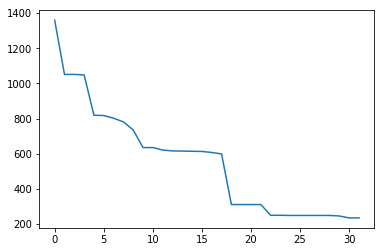

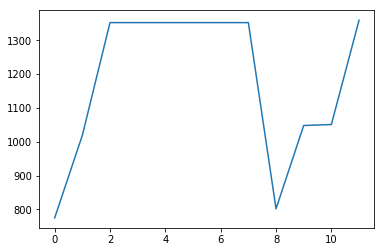

In [ ]:
%%time
env = make_env(version, movement_type)
meteor_no = 4
for meteor in range(meteor_no):
    num_epochs = 100
    first = True
    for epoch in range(num_epochs):
        epoch_count += 1
        max_frames = 2000
        #max_frames = min((1+epoch)*200, 2000)
        agents, fitness_vec, times = evolution_step(env = env, generation = agents,
                         num_agents_per_gen = mario_count, num_survivors = num_survivors, chance = chance, 
                         cancer_level = cancer_level, max_frames = max_frames, fitness_vec = fitness_vec, 
                         buffer = buffer, first = first)
        first = False
        fitness_hist.append(max(fitness_vec))
        clear_output(wait = True)
        
        if fitness_vec[0] > best_score:
            best_agent = copy.deepcopy(agents[0])
            best_score = fitness_vec[0]
            
        print('epoch: ', epoch_count)
        print('fitness_max: ', max(fitness_vec))
        print('times: ', times)
        print('best score: ', best_score)
        plt.plot(fitness_vec)
        plt.show()
        plt.plot(fitness_hist)
        plt.show()
        pickle.dump(agents, open('gen' + name, 'wb'))
        pickle.dump(fitness_hist, open('fithist' + name,'wb'))

In [22]:
import cv2

agent = best_agent

reward_hist = []

frames = []

agent.reset_states()

env = make_env(version, movement_type)
env = wrappers.Monitor(env, "./gym-results", force=True)

agent.reset_states()
reward_hist = []

max_frames = 2000
max_rest = 100

life = 2
fitness = 0
done = True
x_pos = -1
resting = 0
score = 0
action = 0
reward = 0
action_vec = np.ones((1,1,len(env.get_keys_to_action())))
action = 0
prev_reward = 0
prev_state = np.zeros((1,240,256,3))
frames = []
for step in range(max_frames):
    if done:
        state = env.reset()
    if step%buffer == 0:
        np_state = np.array(state).reshape((1,240,256,3)) - prev_state
        frames.append(np_state)
        prev_state = np.array(state).reshape((1,240,256,3))
        action_vec = agent.predict(np_state)
        action = np.argmax(action_vec)
    state, reward, done, info = env.step(action)
    env.render()
    fitness += reward
    if abs(info['x_pos'] - x_pos) < 1:
        resting += 1
    else:
        x_pos = info['x_pos']
        resting = 0
    if resting > max_rest:
        break
    if life != info['life']:
        break
env.close()

(1, 240, 256, 3)


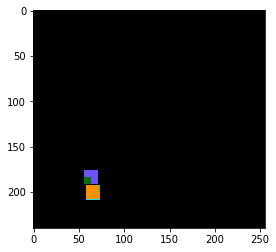

In [38]:
print(np.shape(np_state))
plt.imshow(frames[10][0].astype('int'))
plt.show()

In [11]:
opposite = - agent.predict(np_state)

In [12]:
agent.train_on_batch(np_state, opposite)

Instructions for updating:
Use tf.cast instead.


0.08185966

In [13]:
agent.predict(np_state)

array([[0.1367242 , 0.13543123, 0.15489443, 0.13607913, 0.14449832,
        0.14711556, 0.14525719]], dtype=float32)

In [14]:
opposite

array([[-0.13564147, -0.13456133, -0.15595011, -0.13440834, -0.14566463,
        -0.14708446, -0.14668965]], dtype=float32)

In [15]:
np.shape(gameplay)

()

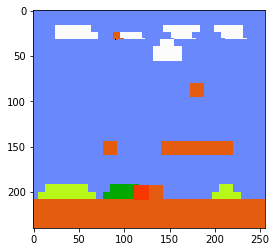

In [16]:
for frame in frames:
    plt.imshow(frame[0])
    plt.show()
    clear_output(wait=True)

In [17]:
np_state

array([[[[104, 136, 252],
         [104, 136, 252],
         [104, 136, 252],
         ...,
         [104, 136, 252],
         [104, 136, 252],
         [104, 136, 252]],

        [[104, 136, 252],
         [104, 136, 252],
         [104, 136, 252],
         ...,
         [104, 136, 252],
         [104, 136, 252],
         [104, 136, 252]],

        [[104, 136, 252],
         [104, 136, 252],
         [104, 136, 252],
         ...,
         [104, 136, 252],
         [104, 136, 252],
         [104, 136, 252]],

        ...,

        [[228,  92,  16],
         [228,  92,  16],
         [228,  92,  16],
         ...,
         [228,  92,  16],
         [228,  92,  16],
         [228,  92,  16]],

        [[228,  92,  16],
         [228,  92,  16],
         [228,  92,  16],
         ...,
         [228,  92,  16],
         [228,  92,  16],
         [228,  92,  16]],

        [[228,  92,  16],
         [228,  92,  16],
         [228,  92,  16],
         ...,
         [228,  92,  16],
        